# Model Evaluation Analysis - Adam Optimizer with Different Activation Functions

This notebook loads trained Adam models (ReLU and Leaky ReLU variants) from the results folders and performs comprehensive evaluation including:
- Train, Validation, and Test Accuracies
- Precision, Recall, F1-Score metrics
- Normalized Confusion Matrix Heatmaps
- Class-wise Performance Analysis

## 1. Import Required Libraries

In [36]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import os
import json
from pathlib import Path

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch Version: 2.8.0+cu126
CUDA Available: True


## 2. Define CNN Model Architecture

In [37]:
class WasteCustomCNN(nn.Module):
    def __init__(self, num_classes=9, activation='relu', dropout_rate=0.3):
        super(WasteCustomCNN, self).__init__()
        
        # Convolutional layers (no batch normalization)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))
        
        # Fully connected layers
        self.fc1 = nn.Linear(8192, 512)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(512, num_classes)
        
                # Activation function
        if activation == 'relu':
            self.relu = nn.ReLU()
        elif activation == 'leaky_relu':
            self.relu = nn.LeakyReLU()
        elif activation == 'leaky_relu_0.5':
            self.relu = nn.LeakyReLU()
        elif activation == 'mish':
            self.relu = nn.Mish()
        else:
            self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

print("Model architecture defined successfully!")

Model architecture defined successfully!


## 3. Setup Data Loaders

In [38]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data paths
data_root = r'e:\CNN-A03\dataloader'
train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'val')
test_dir = os.path.join(data_root, 'test')

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Get class names
class_names = train_dataset.classes
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"\nTrain samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Number of classes: 9
Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

Train samples: 4626
Validation samples: 1828
Test samples: 1859


## 4. Load Trained Adam Models

In [39]:
# Define model configurations
model_configs = [
    {
        'name': 'Mish (dropout=0.3)',
        'path': r'e:\CNN-A03\results mich\models\best_model_WasteCustom_Adam.pth',
        'activation': 'mish',
        'dropout': 0.3
    },
    {
        'name': 'ReLU (dropout=0.5)',
        'path': r'e:\CNN-A03\results relu\models\best_model_WasteCustom_Adam.pth',
        'activation': 'relu',
        'dropout': 0.5
    },
    {
        'name': 'LeakyReLU (dropout=0.3)',
        'path': r'e:\CNN-A03\results leakyrelu 03\models\best_model_WasteCustom_Adam.pth',
        'activation': 'leaky_relu',
        'dropout': 0.3
    },
    {
        'name': 'LeakyReLU (dropout=0.5)',
        'path': r'e:\CNN-A03\results LeakyReLu 05dropout\models\best_model_WasteCustom_Adam.pth',
        'activation': 'leaky_relu_0.5',
        'dropout': 0.5
    }
]

# Load models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

models = {}
for config in model_configs:
    if os.path.exists(config['path']):
        print(f"Loading {config['name']} model...")
        print(f"  - Activation: {config['activation']}")
        print(f"  - Dropout: {config['dropout']}")
        model = WasteCustomCNN(
            num_classes=num_classes,
            activation=config['activation'],
            dropout_rate=config['dropout']
        )
        model.load_state_dict(torch.load(config['path'], map_location=device))
        model = model.to(device)
        model.eval()
        models[config['name']] = model
        print(f"✓ {config['name']} model loaded successfully!\n")
    else:
        print(f"✗ Model file not found: {config['path']}\n")

print(f"Total models loaded: {len(models)}")

Using device: cuda

Loading Mish (dropout=0.3) model...
  - Activation: mish
  - Dropout: 0.3
✓ Mish (dropout=0.3) model loaded successfully!

Loading ReLU (dropout=0.5) model...
  - Activation: relu
  - Dropout: 0.5
Loading ReLU (dropout=0.5) model...
  - Activation: relu
  - Dropout: 0.5
✓ ReLU (dropout=0.5) model loaded successfully!

Loading LeakyReLU (dropout=0.3) model...
  - Activation: leaky_relu
  - Dropout: 0.3
✓ ReLU (dropout=0.5) model loaded successfully!

Loading LeakyReLU (dropout=0.3) model...
  - Activation: leaky_relu
  - Dropout: 0.3
✓ LeakyReLU (dropout=0.3) model loaded successfully!

Loading LeakyReLU (dropout=0.5) model...
  - Activation: leaky_relu_0.5
  - Dropout: 0.5
✓ LeakyReLU (dropout=0.5) model loaded successfully!

Total models loaded: 4
✓ LeakyReLU (dropout=0.3) model loaded successfully!

Loading LeakyReLU (dropout=0.5) model...
  - Activation: leaky_relu_0.5
  - Dropout: 0.5
✓ LeakyReLU (dropout=0.5) model loaded successfully!

Total models loaded: 4


## 5. Evaluation Functions

In [40]:
def evaluate_model(model, data_loader, device):
    """
    Evaluate model on a dataset and return predictions and true labels
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

def calculate_metrics(y_true, y_pred):
    """
    Calculate accuracy, precision, recall, and F1-score
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    
    return {
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1_score': f1 * 100
    }

def get_class_wise_metrics(y_true, y_pred, class_names):
    """
    Get class-wise precision, recall, and F1-score
    """
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
    
    class_metrics = []
    for i, class_name in enumerate(class_names):
        class_metrics.append({
            'Class': class_name,
            'Precision': precision[i] * 100,
            'Recall': recall[i] * 100,
            'F1-Score': f1[i] * 100,
            'Support': support[i]
        })
    
    return pd.DataFrame(class_metrics)

print("Evaluation functions defined successfully!")

Evaluation functions defined successfully!


## 6. Evaluate All Models on Train, Validation, and Test Data

In [41]:
# Store results for all models
results = {}

print("Evaluating all models...")
print(f"{'='*80}")

for model_name, model in models.items():
    # Evaluate on train set
    train_preds, train_labels = evaluate_model(model, train_loader, device)
    train_metrics = calculate_metrics(train_labels, train_preds)
    
    # Evaluate on validation set
    val_preds, val_labels = evaluate_model(model, val_loader, device)
    val_metrics = calculate_metrics(val_labels, val_preds)
    
    # Evaluate on test set
    test_preds, test_labels = evaluate_model(model, test_loader, device)
    test_metrics = calculate_metrics(test_labels, test_preds)
    
    # Store results
    results[model_name] = {
        'train': {
            'metrics': train_metrics,
            'predictions': train_preds,
            'labels': train_labels
        },
        'val': {
            'metrics': val_metrics,
            'predictions': val_preds,
            'labels': val_labels
        },
        'test': {
            'metrics': test_metrics,
            'predictions': test_preds,
            'labels': test_labels
        }
    }

# Print clean summary for all models
print("\nModel Evaluation Results:")
print(f"{'='*80}")
print(f"{'Model':<25} {'Train Acc':<12} {'Val Acc':<12} {'Test Acc':<12}")
print(f"{'-'*80}")
for model_name, result in results.items():
    train_acc = result['train']['metrics']['accuracy']
    val_acc = result['val']['metrics']['accuracy']
    test_acc = result['test']['metrics']['accuracy']
    print(f"{model_name:<25} {train_acc:>10.2f}%  {val_acc:>10.2f}%  {test_acc:>10.2f}%")
print(f"{'='*80}")
print("Evaluation completed for all models!")

Evaluating all models...

Model Evaluation Results:
Model                     Train Acc    Val Acc      Test Acc    
--------------------------------------------------------------------------------
Mish (dropout=0.3)             91.70%       91.03%       91.34%
ReLU (dropout=0.5)             80.63%       78.12%       78.81%
LeakyReLU (dropout=0.3)        92.28%       91.79%       92.95%
LeakyReLU (dropout=0.5)        89.54%       89.22%       90.21%
Evaluation completed for all models!

Model Evaluation Results:
Model                     Train Acc    Val Acc      Test Acc    
--------------------------------------------------------------------------------
Mish (dropout=0.3)             91.70%       91.03%       91.34%
ReLU (dropout=0.5)             80.63%       78.12%       78.81%
LeakyReLU (dropout=0.3)        92.28%       91.79%       92.95%
LeakyReLU (dropout=0.5)        89.54%       89.22%       90.21%
Evaluation completed for all models!


## 7. Summary Table - Overall Metrics

In [42]:
# Create summary dataframe
summary_data = []
for model_name, result in results.items():
    for dataset_type in ['train', 'val', 'test']:
        metrics = result[dataset_type]['metrics']
        summary_data.append({
            'Model': model_name,
            'Dataset': dataset_type.capitalize(),
            'Accuracy (%)': f"{metrics['accuracy']:.2f}",
            'Precision (%)': f"{metrics['precision']:.2f}",
            'Recall (%)': f"{metrics['recall']:.2f}",
            'F1-Score (%)': f"{metrics['f1_score']:.2f}"
        })

summary_df = pd.DataFrame(summary_data)

# Display the summary table
print("\n" + "="*80)
print("SUMMARY: Overall Performance Metrics for All Models")
print("="*80 + "\n")
print(summary_df.to_string(index=False))
print("\n" + "="*80)


SUMMARY: Overall Performance Metrics for All Models

                  Model Dataset Accuracy (%) Precision (%) Recall (%) F1-Score (%)
     Mish (dropout=0.3)   Train        91.70         91.82      91.70        91.66
     Mish (dropout=0.3)     Val        91.03         91.16      91.03        91.03
     Mish (dropout=0.3)    Test        91.34         91.43      91.34        91.31
     ReLU (dropout=0.5)   Train        80.63         80.79      80.63        80.43
     ReLU (dropout=0.5)     Val        78.12         78.41      78.12        77.94
     ReLU (dropout=0.5)    Test        78.81         78.99      78.81        78.55
LeakyReLU (dropout=0.3)   Train        92.28         92.30      92.28        92.25
LeakyReLU (dropout=0.3)     Val        91.79         91.85      91.79        91.77
LeakyReLU (dropout=0.3)    Test        92.95         92.93      92.95        92.93
LeakyReLU (dropout=0.5)   Train        89.54         89.55      89.54        89.47
LeakyReLU (dropout=0.5)     Val  

## 8. Normalized Confusion Matrices (Accuracy-based Heatmaps)


Generating confusion matrix for Mish (dropout=0.3)...


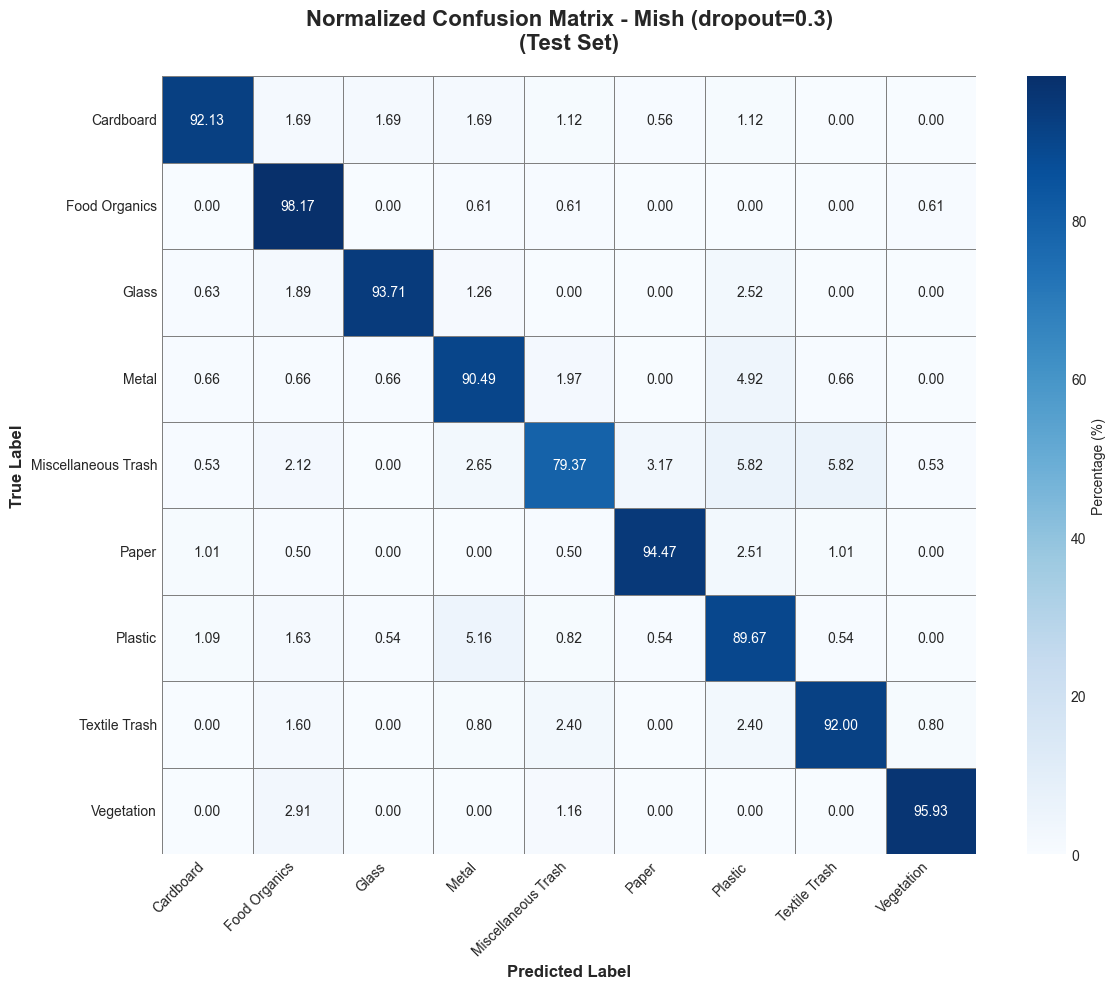


Generating confusion matrix for ReLU (dropout=0.5)...


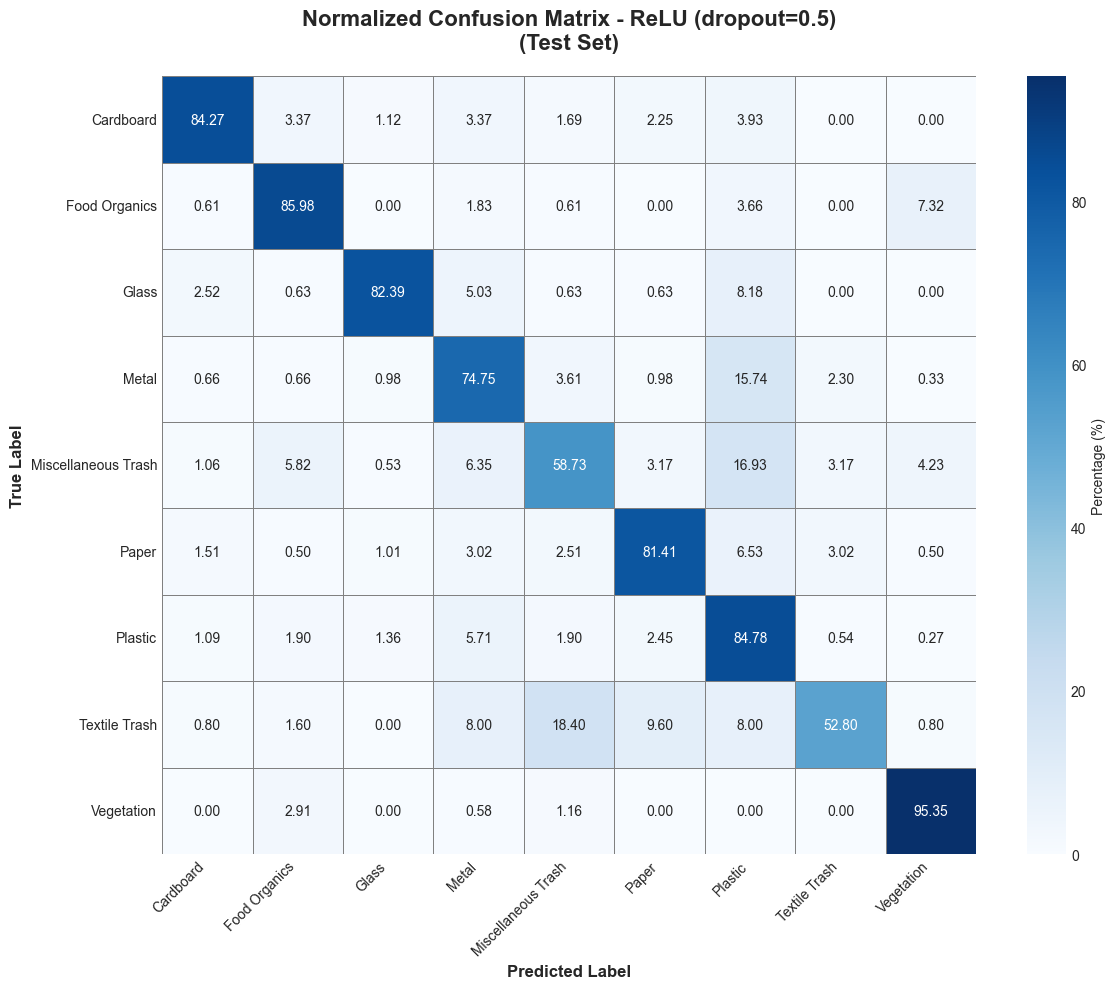


Generating confusion matrix for LeakyReLU (dropout=0.3)...


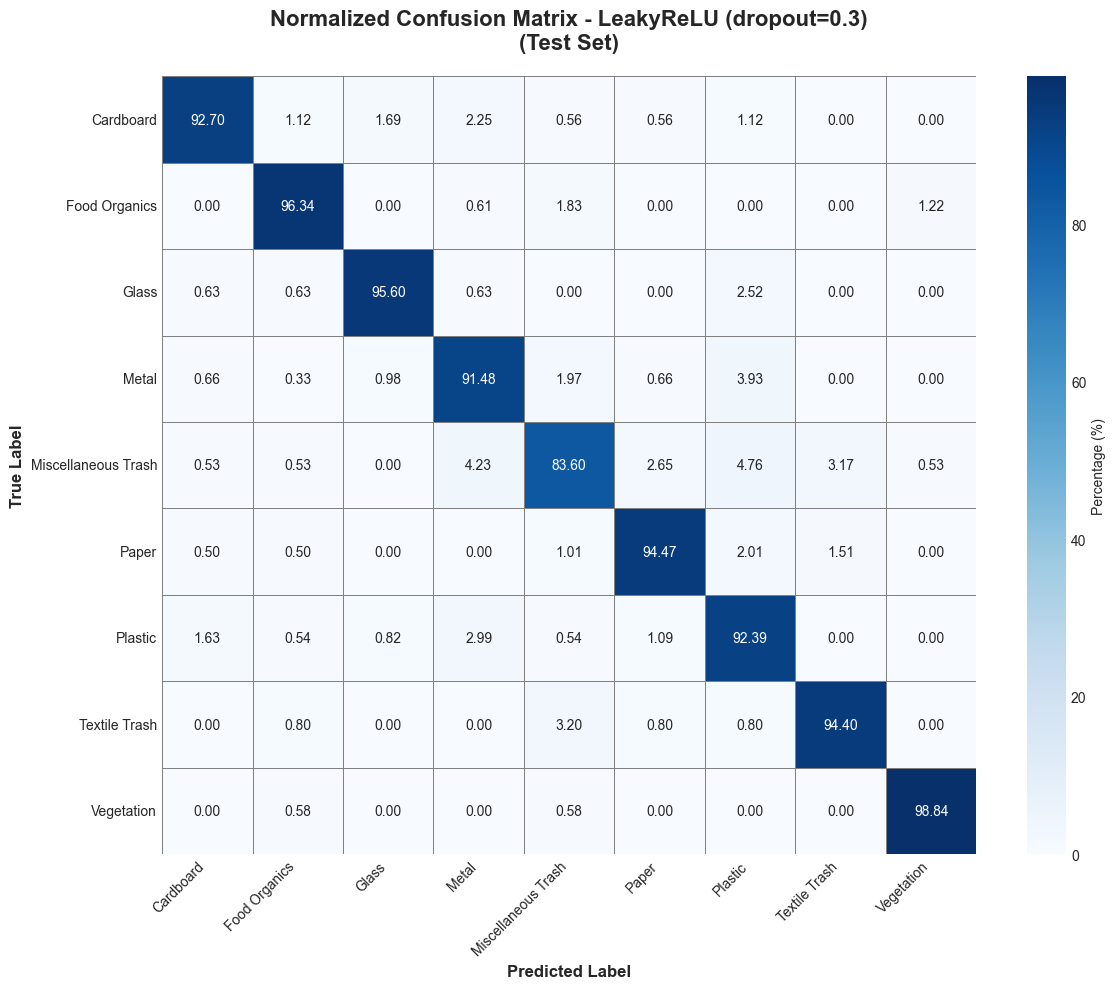


Generating confusion matrix for LeakyReLU (dropout=0.5)...


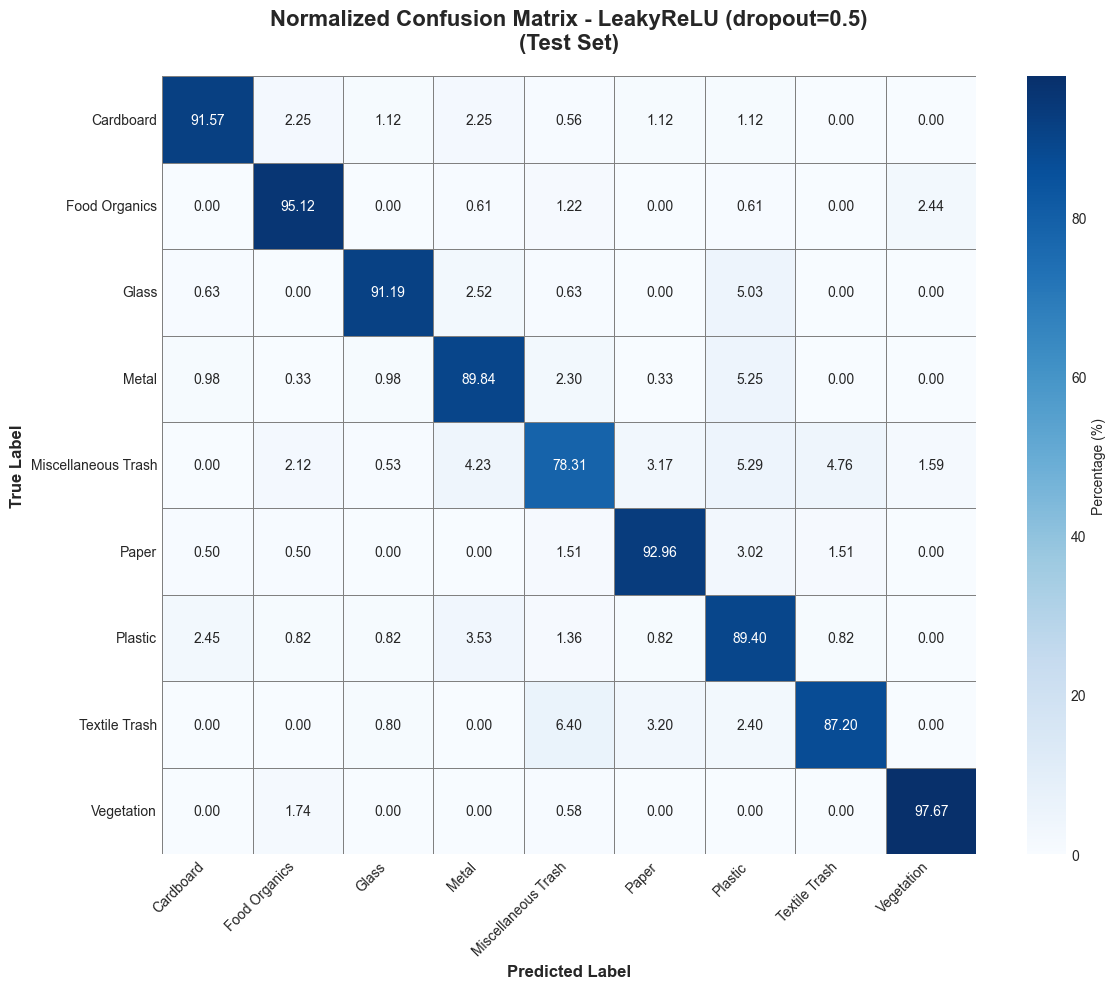


All confusion matrices generated successfully!


In [43]:
def plot_confusion_matrix(y_true, y_pred, class_names, title, normalize=True):
    """
    Plot confusion matrix as a heatmap with normalized values (percentages)
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize to percentages
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', 
                cmap='Blues', xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Percentage (%)' if normalize else 'Count'},
                linewidths=0.5, linecolor='gray')
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    return plt.gcf()

# Generate confusion matrices for test data
for model_name, result in results.items():
    print(f"\nGenerating confusion matrix for {model_name}...")
    
    test_preds = result['test']['predictions']
    test_labels = result['test']['labels']
    
    fig = plot_confusion_matrix(
        test_labels, 
        test_preds, 
        class_names, 
        f'Normalized Confusion Matrix - {model_name}\n(Test Set)',
        normalize=True
    )
    
    plt.show()

print("\nAll confusion matrices generated successfully!")

## 9. Confusion Matrices for Training Data


Generating training confusion matrix for Mish (dropout=0.3)...


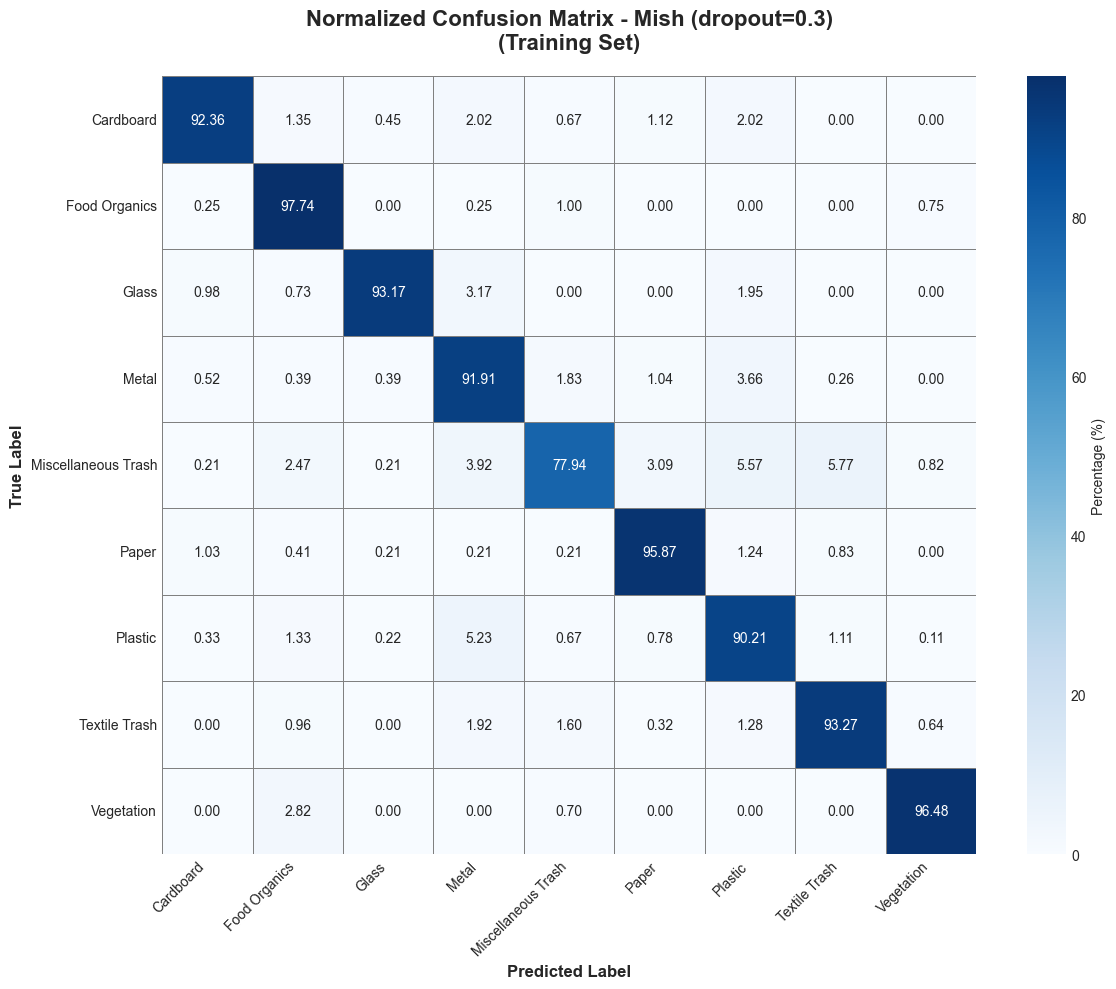


Generating training confusion matrix for ReLU (dropout=0.5)...


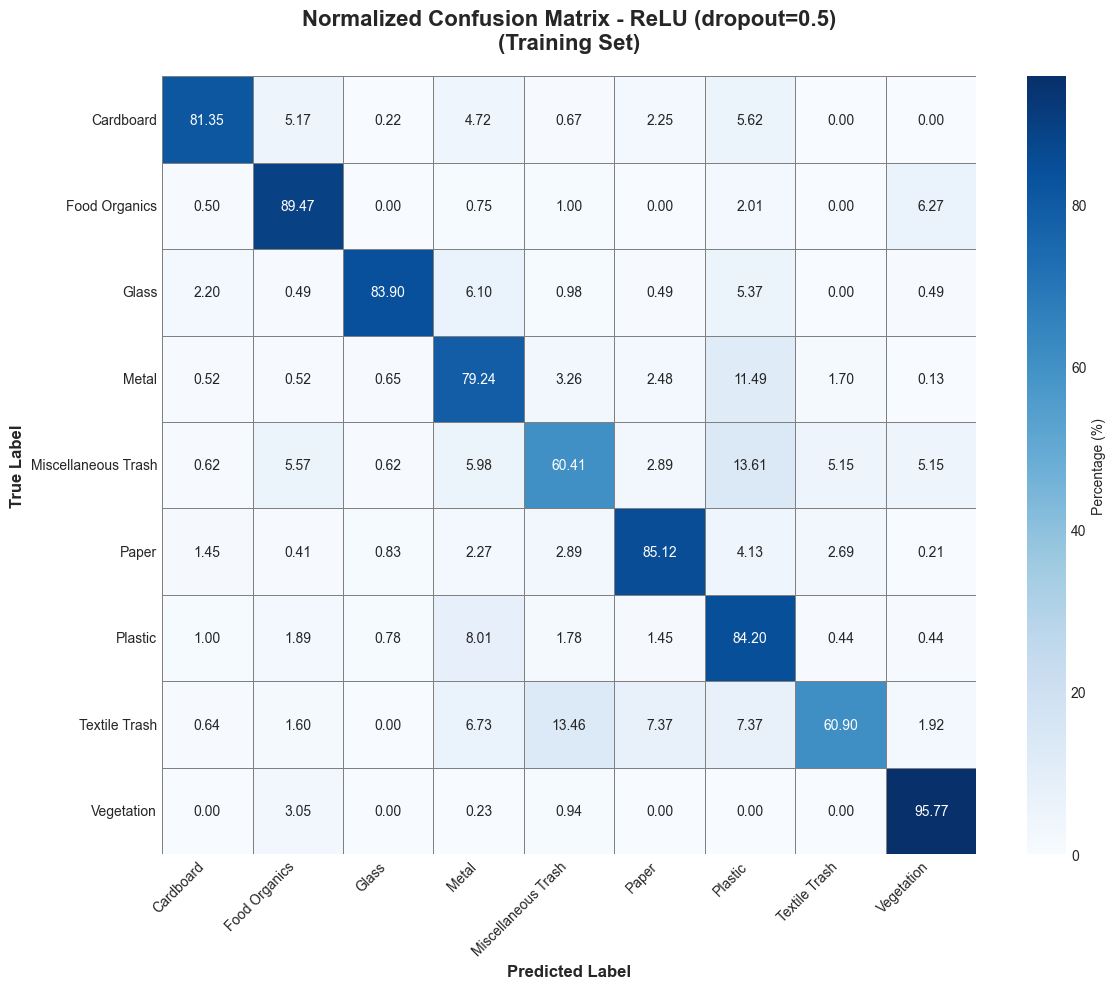


Generating training confusion matrix for LeakyReLU (dropout=0.3)...


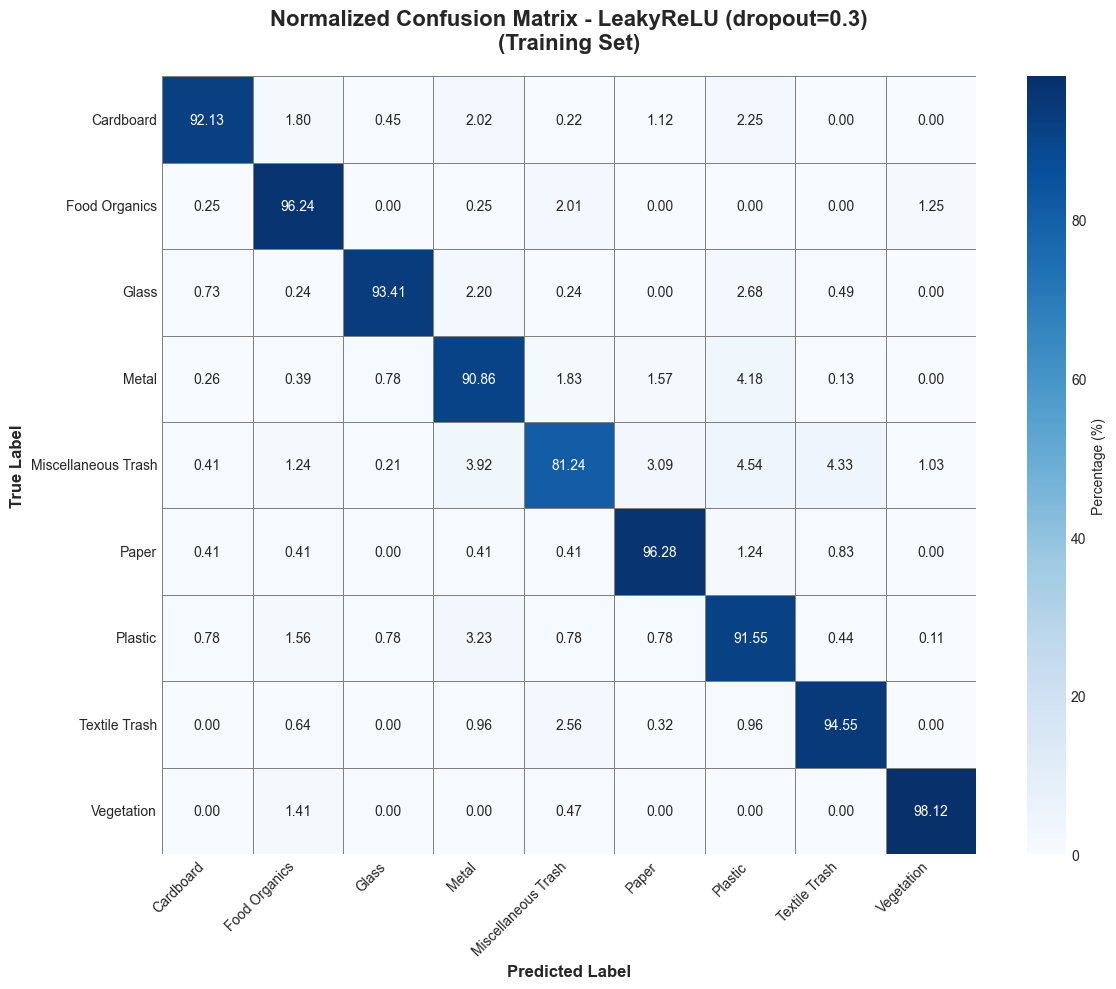


Generating training confusion matrix for LeakyReLU (dropout=0.5)...


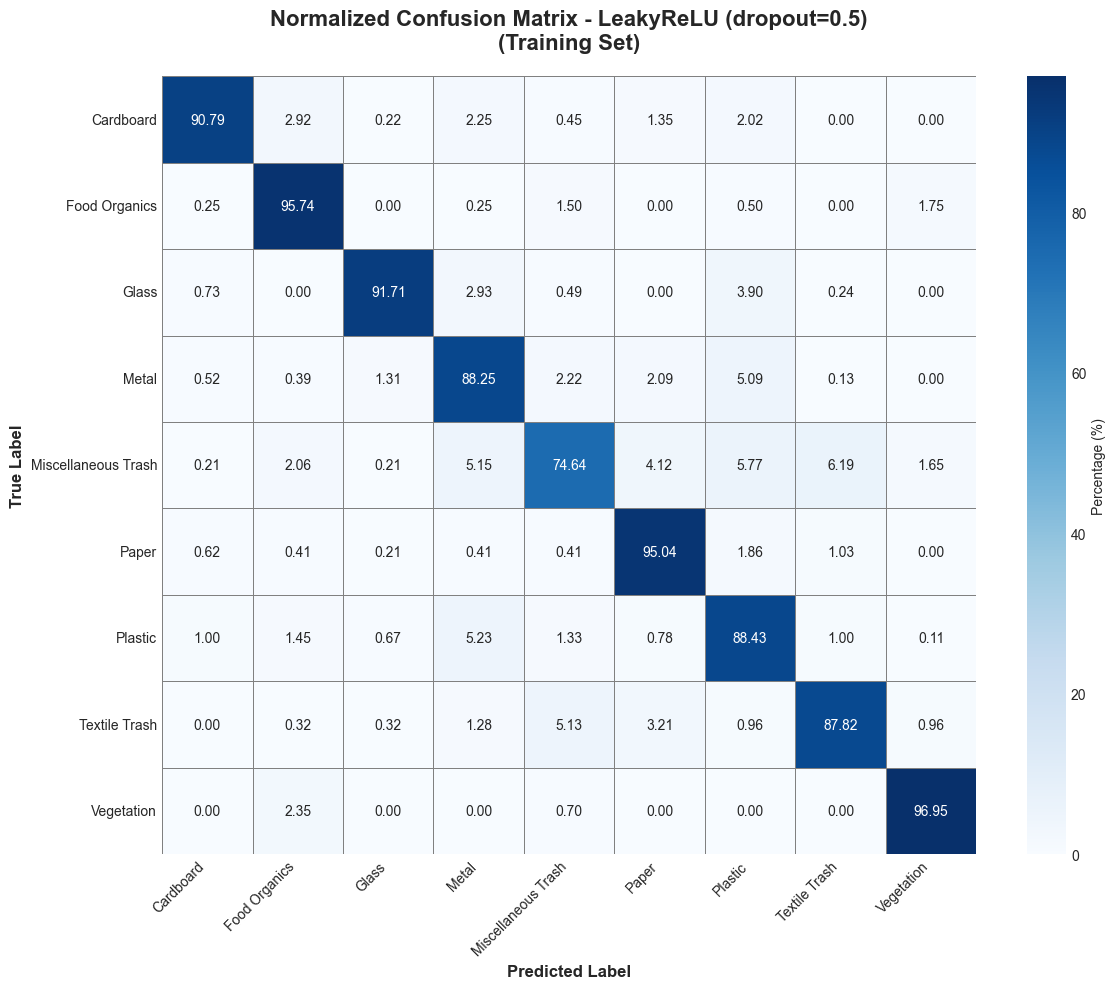


All training confusion matrices generated successfully!


In [44]:
# Generate confusion matrices for training data
for model_name, result in results.items():
    print(f"\nGenerating training confusion matrix for {model_name}...")
    
    train_preds = result['train']['predictions']
    train_labels = result['train']['labels']
    
    fig = plot_confusion_matrix(
        train_labels, 
        train_preds, 
        class_names, 
        f'Normalized Confusion Matrix - {model_name}\n(Training Set)',
        normalize=True
    )
    
    plt.show()

print("\nAll training confusion matrices generated successfully!")

## 10. Class-wise Performance Analysis (Test Set)

In [45]:
# Display class-wise metrics for each model on test set
for model_name, result in results.items():
    print(f"\n{'='*80}")
    print(f"Class-wise Performance - {model_name} (Test Set)")
    print(f"{'='*80}\n")
    
    test_preds = result['test']['predictions']
    test_labels = result['test']['labels']
    
    class_metrics_df = get_class_wise_metrics(test_labels, test_preds, class_names)
    print(class_metrics_df.to_string(index=False))
    
    # Store for visualization
    result['test']['class_metrics'] = class_metrics_df

print(f"\n{'='*80}")
print("Class-wise analysis completed!")
print(f"{'='*80}")


Class-wise Performance - Mish (dropout=0.3) (Test Set)

              Class  Precision    Recall  F1-Score  Support
          Cardboard  94.252874 92.134831 93.181818      178
      Food Organics  86.096257 98.170732 91.737892      164
              Glass  95.512821 93.710692 94.603175      159
              Metal  89.902280 90.491803 90.196078      305
Miscellaneous Trash  89.285714 79.365079 84.033613      189
              Paper  95.431472 94.472362 94.949495      199
            Plastic  89.189189 89.673913 89.430894      368
      Textile Trash  87.121212 92.000000 89.494163      125
         Vegetation  98.214286 95.930233 97.058824      172

Class-wise Performance - ReLU (dropout=0.5) (Test Set)

              Class  Precision    Recall  F1-Score  Support
          Cardboard  89.820359 84.269663 86.956522      178
      Food Organics  80.113636 85.975610 82.941176      164
              Glass  90.972222 82.389937 86.468647      159
              Metal  77.288136 74.754098 76.00

## 11. Class-wise Performance Analysis (Training Set)

In [46]:
# Display class-wise metrics for each model on training set
for model_name, result in results.items():
    print(f"\n{'='*80}")
    print(f"Class-wise Performance - {model_name} (Training Set)")
    print(f"{'='*80}\n")
    
    train_preds = result['train']['predictions']
    train_labels = result['train']['labels']
    
    class_metrics_df = get_class_wise_metrics(train_labels, train_preds, class_names)
    print(class_metrics_df.to_string(index=False))
    
    # Store for visualization
    result['train']['class_metrics'] = class_metrics_df

print(f"\n{'='*80}")
print("Training class-wise analysis completed!")
print(f"{'='*80}")


Class-wise Performance - Mish (dropout=0.3) (Training Set)

              Class  Precision    Recall  F1-Score  Support
          Cardboard  95.804196 92.359551 94.050343      445
      Food Organics  88.036117 97.744361 92.636580      399
              Glass  97.698210 93.170732 95.380774      410
              Metal  88.000000 91.906005 89.910600      766
Miscellaneous Trash  91.304348 77.938144 84.093437      485
              Paper  92.800000 95.867769 94.308943      484
            Plastic  90.817469 90.211346 90.513393      899
      Textile Trash  86.865672 93.269231 89.953632      312
         Vegetation  97.624703 96.478873 97.048406      426

Class-wise Performance - ReLU (dropout=0.5) (Training Set)

              Class  Precision    Recall  F1-Score  Support
          Cardboard  90.954774 81.348315 85.883749      445
      Food Organics  79.333333 89.473684 84.098940      399
              Glass  94.505495 83.902439 88.888889      410
              Metal  76.835443 79.2428

## 12. Visualize Class-wise Performance Comparison

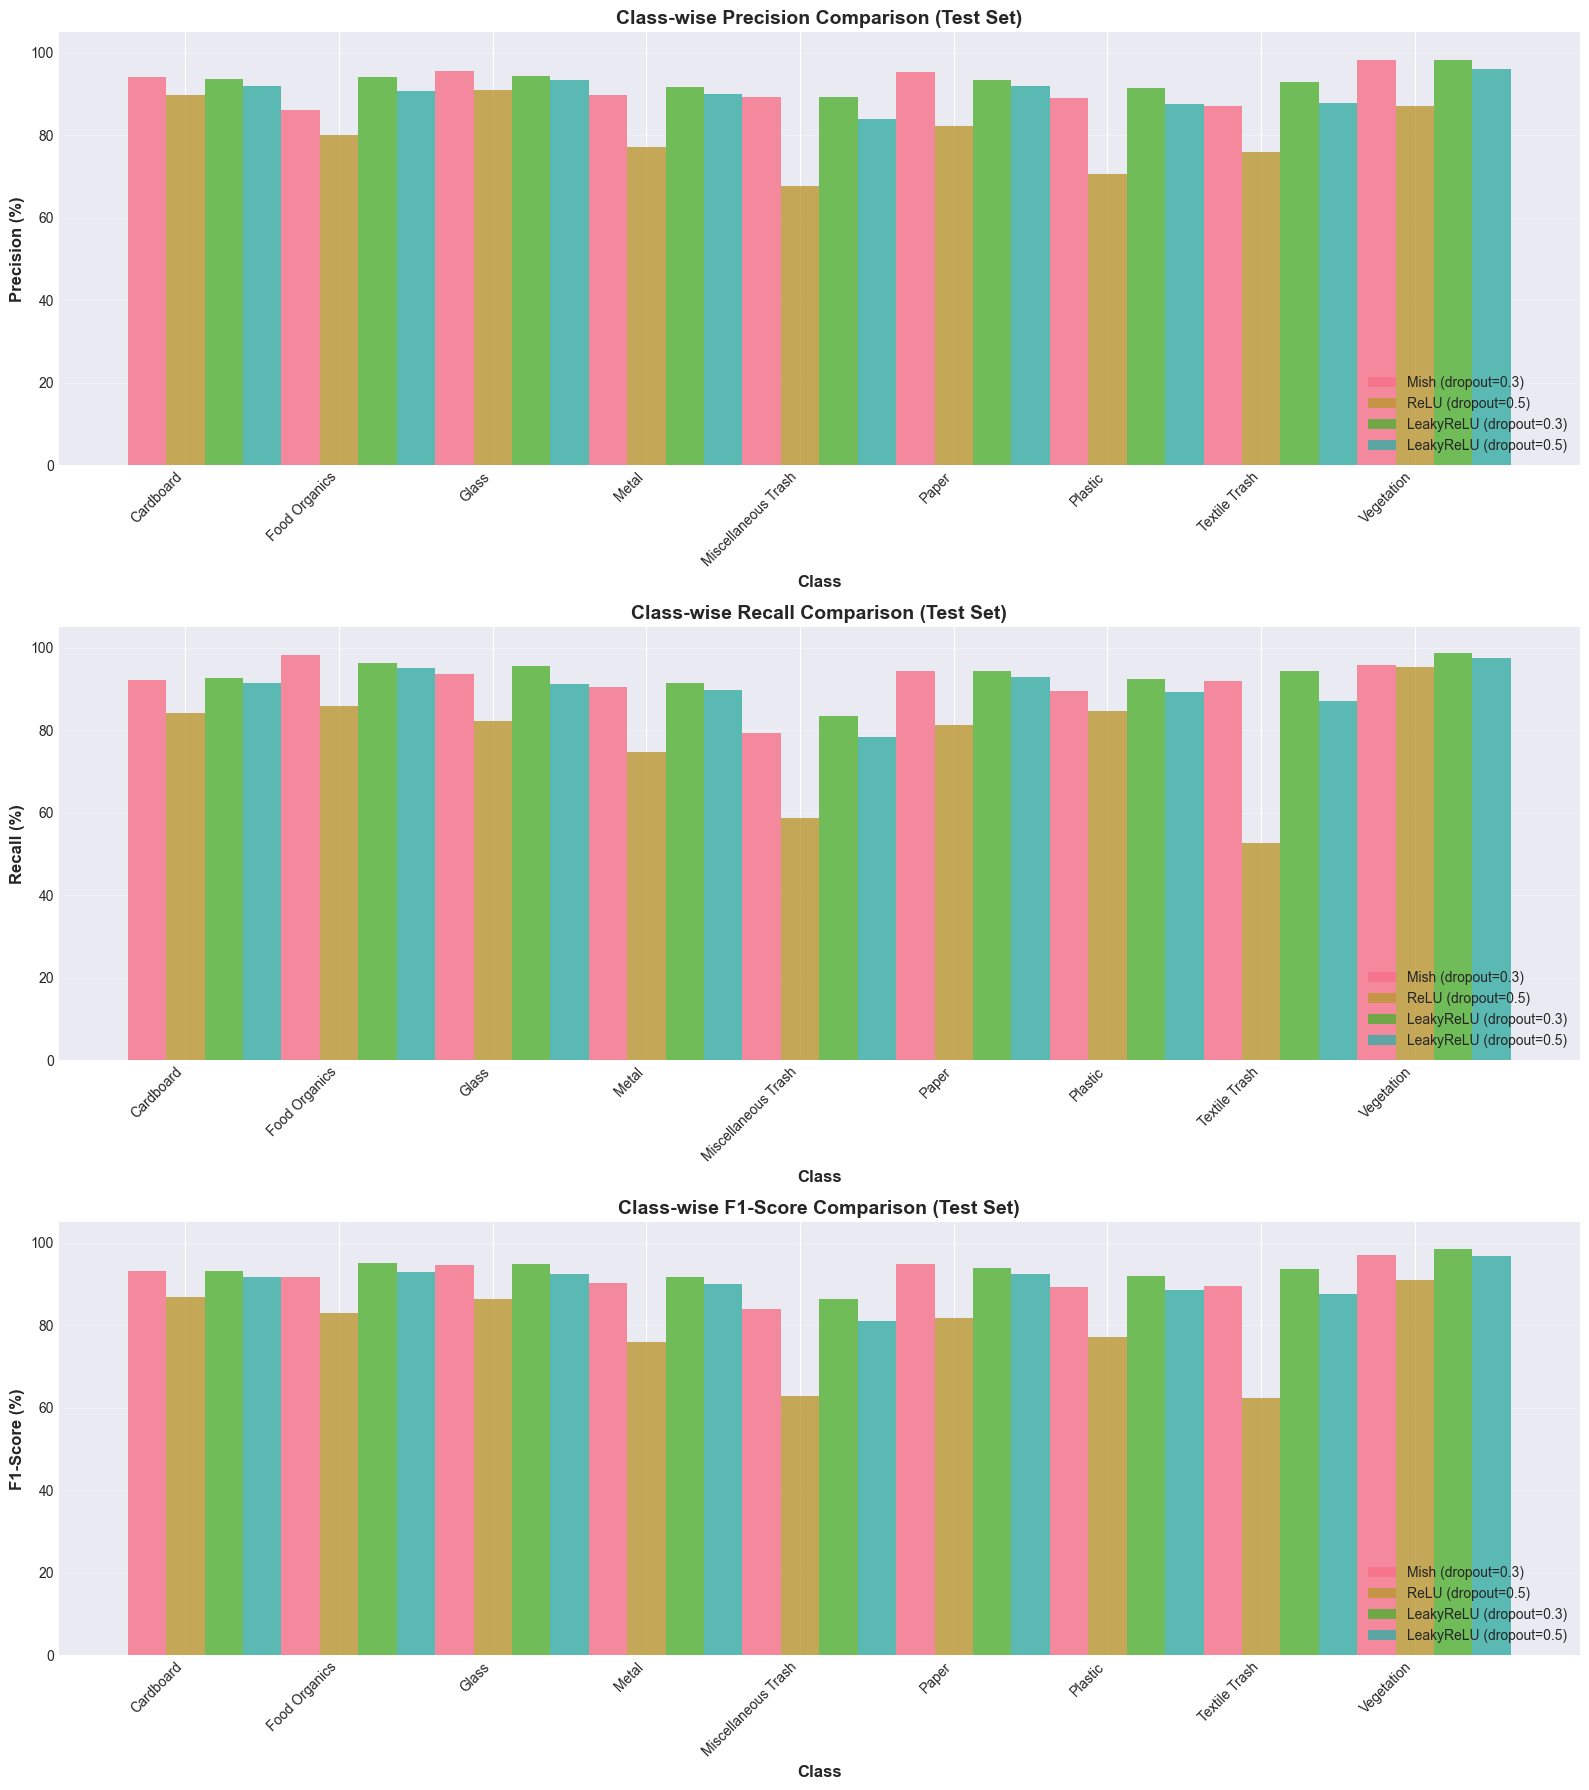

Class-wise comparison visualization completed!


In [47]:
# Visualize class-wise precision, recall, and F1-score for all models (Test Set)
fig, axes = plt.subplots(3, 1, figsize=(16, 18))

metrics_to_plot = ['Precision', 'Recall', 'F1-Score']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    # Prepare data for grouped bar chart
    x = np.arange(len(class_names))
    width = 0.25
    
    for i, (model_name, result) in enumerate(results.items()):
        class_metrics_df = result['test']['class_metrics']
        values = class_metrics_df[metric].values
        ax.bar(x + i * width, values, width, label=model_name, alpha=0.8)
    
    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'{metric} (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'Class-wise {metric} Comparison (Test Set)', fontsize=14, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend(loc='lower right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 105])

plt.tight_layout()
plt.show()

print("Class-wise comparison visualization completed!")

## 13. Overall Accuracy Comparison Across Datasets

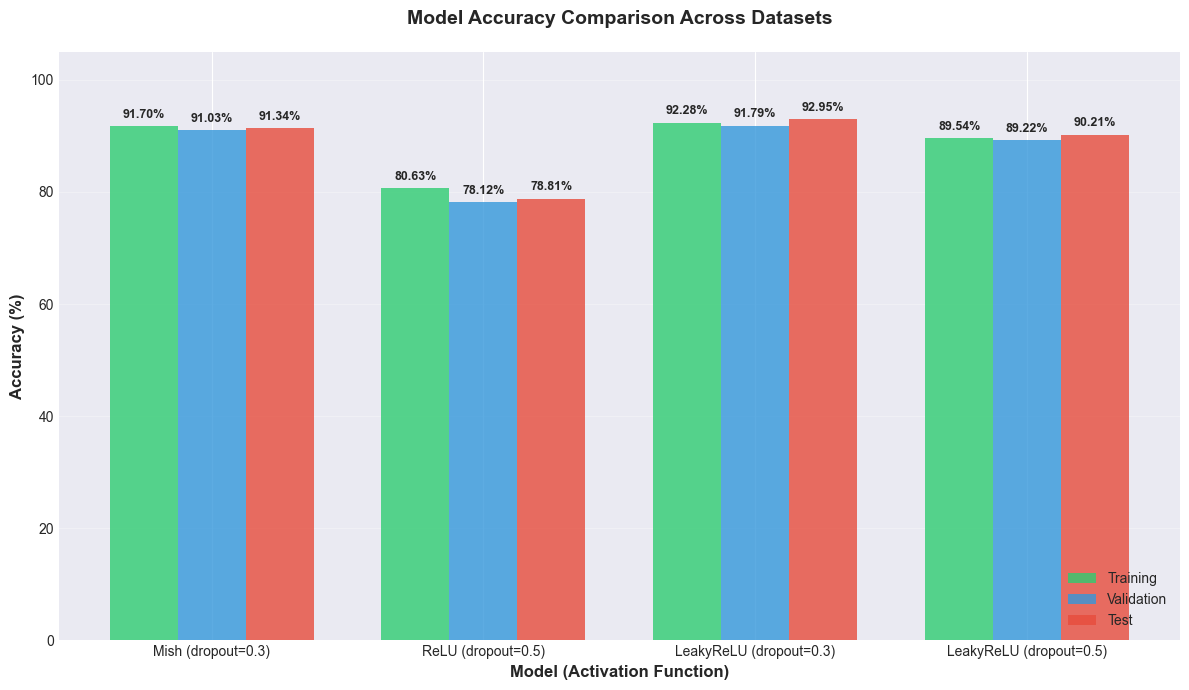

Accuracy comparison visualization completed!


In [48]:
# Create accuracy comparison chart
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(results))
width = 0.25

datasets = ['train', 'val', 'test']
dataset_labels = ['Training', 'Validation', 'Test']
colors = ['#2ecc71', '#3498db', '#e74c3c']

for i, (dataset, label, color) in enumerate(zip(datasets, dataset_labels, colors)):
    accuracies = [results[model_name][dataset]['metrics']['accuracy'] for model_name in results.keys()]
    ax.bar(x + i * width, accuracies, width, label=label, color=color, alpha=0.8)
    
    # Add value labels on bars
    for j, acc in enumerate(accuracies):
        ax.text(j + i * width, acc + 1, f'{acc:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Model (Activation Function)', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Accuracy Comparison Across Datasets', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x + width)
ax.set_xticklabels(list(results.keys()))
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 105])

plt.tight_layout()
plt.show()

print("Accuracy comparison visualization completed!")

## 14. Precision, Recall, F1-Score Comparison (Test Set)

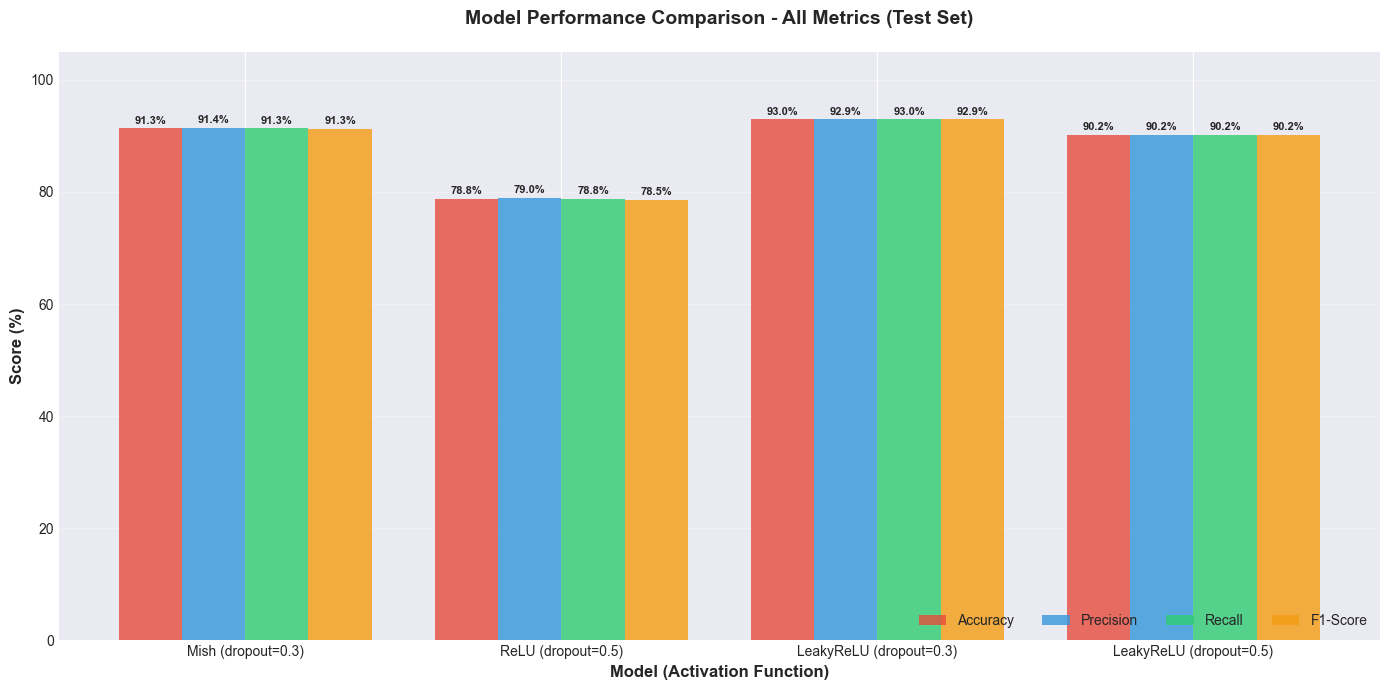

All metrics comparison visualization completed!


In [49]:
# Create grouped bar chart for all metrics on test set
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(results))
width = 0.2

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']

for i, (metric, label, color) in enumerate(zip(metrics, metric_labels, colors)):
    values = [results[model_name]['test']['metrics'][metric] for model_name in results.keys()]
    bars = ax.bar(x + i * width, values, width, label=label, color=color, alpha=0.8)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

ax.set_xlabel('Model (Activation Function)', fontsize=12, fontweight='bold')
ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison - All Metrics (Test Set)', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(list(results.keys()))
ax.legend(loc='lower right', ncol=4)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 105])

plt.tight_layout()
plt.show()

print("All metrics comparison visualization completed!")

## 15. Detailed Classification Reports (Test Set)

In [50]:
# Print detailed classification reports for test set
for model_name, result in results.items():
    print(f"\n{'='*80}")
    print(f"DETAILED CLASSIFICATION REPORT - {model_name} (Test Set)")
    print(f"{'='*80}\n")
    
    test_preds = result['test']['predictions']
    test_labels = result['test']['labels']
    
    report = classification_report(test_labels, test_preds, target_names=class_names, digits=4)
    print(report)

print(f"\n{'='*80}")
print("All classification reports generated!")
print(f"{'='*80}")


DETAILED CLASSIFICATION REPORT - Mish (dropout=0.3) (Test Set)

                     precision    recall  f1-score   support

          Cardboard     0.9425    0.9213    0.9318       178
      Food Organics     0.8610    0.9817    0.9174       164
              Glass     0.9551    0.9371    0.9460       159
              Metal     0.8990    0.9049    0.9020       305
Miscellaneous Trash     0.8929    0.7937    0.8403       189
              Paper     0.9543    0.9447    0.9495       199
            Plastic     0.8919    0.8967    0.8943       368
      Textile Trash     0.8712    0.9200    0.8949       125
         Vegetation     0.9821    0.9593    0.9706       172

           accuracy                         0.9134      1859
          macro avg     0.9167    0.9177    0.9163      1859
       weighted avg     0.9143    0.9134    0.9131      1859


DETAILED CLASSIFICATION REPORT - ReLU (dropout=0.5) (Test Set)

                     precision    recall  f1-score   support

          Ca

## 16. Summary and Conclusions

In [51]:
# Generate summary statistics
print("\n" + "="*80)
print("FINAL SUMMARY - MODEL COMPARISON")
print("="*80 + "\n")

# Find best model for each metric on test set
metrics_summary = {
    'Test Accuracy': {},
    'Test Precision': {},
    'Test Recall': {},
    'Test F1-Score': {}
}

for model_name, result in results.items():
    test_metrics = result['test']['metrics']
    metrics_summary['Test Accuracy'][model_name] = test_metrics['accuracy']
    metrics_summary['Test Precision'][model_name] = test_metrics['precision']
    metrics_summary['Test Recall'][model_name] = test_metrics['recall']
    metrics_summary['Test F1-Score'][model_name] = test_metrics['f1_score']

print("Best Performing Models:\n")
for metric_name, metric_values in metrics_summary.items():
    best_model = max(metric_values, key=metric_values.get)
    best_value = metric_values[best_model]
    print(f"{metric_name:20s}: {best_model:25s} ({best_value:.2f}%)")

print("\n" + "="*80)
print("\nKey Findings:")
print("-" * 80)

# Calculate average metrics for each model
for model_name, result in results.items():
    test_metrics = result['test']['metrics']
    avg_metric = (test_metrics['accuracy'] + test_metrics['precision'] + 
                  test_metrics['recall'] + test_metrics['f1_score']) / 4
    print(f"\n{model_name}:")
    print(f"  Average Test Performance: {avg_metric:.2f}%")
    print(f"  Test Accuracy:  {test_metrics['accuracy']:.2f}%")
    print(f"  Test Precision: {test_metrics['precision']:.2f}%")
    print(f"  Test Recall:    {test_metrics['recall']:.2f}%")
    print(f"  Test F1-Score:  {test_metrics['f1_score']:.2f}%")

print("\n" + "="*80)
print("Analysis Complete!")
print("="*80)


FINAL SUMMARY - MODEL COMPARISON

Best Performing Models:

Test Accuracy       : LeakyReLU (dropout=0.3)   (92.95%)
Test Precision      : LeakyReLU (dropout=0.3)   (92.93%)
Test Recall         : LeakyReLU (dropout=0.3)   (92.95%)
Test F1-Score       : LeakyReLU (dropout=0.3)   (92.93%)


Key Findings:
--------------------------------------------------------------------------------

Mish (dropout=0.3):
  Average Test Performance: 91.36%
  Test Accuracy:  91.34%
  Test Precision: 91.43%
  Test Recall:    91.34%
  Test F1-Score:  91.31%

ReLU (dropout=0.5):
  Average Test Performance: 78.79%
  Test Accuracy:  78.81%
  Test Precision: 78.99%
  Test Recall:    78.81%
  Test F1-Score:  78.55%

LeakyReLU (dropout=0.3):
  Average Test Performance: 92.94%
  Test Accuracy:  92.95%
  Test Precision: 92.93%
  Test Recall:    92.95%
  Test F1-Score:  92.93%

LeakyReLU (dropout=0.5):
  Average Test Performance: 90.19%
  Test Accuracy:  90.21%
  Test Precision: 90.17%
  Test Recall:    90.21%
  Test